# Clustering customer behaviours 

In [1]:
import pandas as pd
import numpy as np

retail_data= pd.read_csv('retail_data.csv')

In [2]:
retail_data

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,distance_to_store,holiday_season,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase
0,1,56,Other,High,No,0,No,Divorced,3,Bachelor's,...,33.21,No,Spring,Yes,5,No,High,30,High,40
1,2,69,Female,Medium,No,2,No,Married,2,PhD,...,62.56,No,Summer,Yes,6,No,High,40,Medium,338
2,3,46,Female,Low,No,5,No,Married,3,Bachelor's,...,83.04,Yes,Winter,Yes,2,Yes,Low,89,Medium,61
3,4,32,Female,Low,No,0,No,Divorced,2,Master's,...,50.43,Yes,Winter,No,12,No,Low,12,Low,42
4,5,60,Female,Low,Yes,7,Yes,Divorced,2,Bachelor's,...,36.55,Yes,Summer,Yes,3,No,Medium,31,Low,242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999996,39,Female,Low,No,1,Yes,Married,4,High School,...,10.55,Yes,Spring,No,5,Yes,Low,75,High,163
999996,999997,77,Female,Low,No,4,Yes,Single,2,Master's,...,8.08,Yes,Winter,No,5,No,Low,60,Low,12
999997,999998,67,Male,Medium,No,7,Yes,Single,3,Bachelor's,...,87.26,Yes,Summer,Yes,17,No,High,14,Medium,118
999998,999999,36,Male,Low,Yes,1,Yes,Divorced,2,High School,...,94.17,Yes,Winter,No,13,Yes,Medium,87,High,240


In [3]:
retail_data.drop(columns=['customer_id','transaction_id','customer_zip_code','promotion_id','store_zip_code','product_id'], inplace=True)
retail_data.shape

(1000000, 72)

### Visualise data set


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
date_cols = ['transaction_date', 'promotion_start_date', 'promotion_end_date', 'last_purchase_date', 'product_manufacture_date',
 'product_expiry_date']
for col in date_cols:
    retail_data[col] = pd.to_datetime(retail_data[col], errors='coerce',dayfirst=True)
non_numeric_cols = retail_data.select_dtypes(include=['object', 'category']).columns.tolist()

## “Can we cluster online customers by their purchase behaviour and engagement to uncover actionable segments, and then predict which segment is at highest risk of churn in the next quarter?”

Context: Retailer need to cater promotions to a specific group of customers to ensure they remain engaged. To uncover actionable steps to take to ensure that this is the case, retailers often search for risks of a customer churning (stopping consumption). 

### Pipeline for this project:

Step 1: **Data preprocessing** involes handling missing values (if any), encoding any string category variables and normalisation of skewed distributions.

Step 1.5: **Exploratory Data Analysis** to visualise data and distributions. Perform statistical tests for skewedness and normality. 

Step 2: **Feature Engineering** involves aggregation by different customers (not applicable), assessing RFM (recency, frequency and monetary) metrics, engagement metrics and churn risk metrics. To measure successful outcomes, average promotion effectiveness and frequency of promotion type presented can be used

Step 3: **Clustering** involves using selected inputs on model types such as KNN, GMM and HDBSCAN. Visualisations can be made using PCA. Appropriate cluster labels need to be determined.

Step 3.5: **A/B testing** on clusters to determine underlying relations such as location, product offerrings and loyalty program.

Step 4: **Predicting churn by cluster** invovles using churned variable as the target to test accuracy and AUC/ROC curves while cluster labels are the features

#### Step 1: Data Preprocessing

In [7]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [10]:
processed_data= retail_data.copy()
ordinal_cols=['income_bracket','education_level','promotion_effectiveness','app_usage','social_media_engagement']
ordinal_mappings = {
    'income_bracket': {'Low': 1, 'Medium': 2, 'High': 3},
    'education_level': {'High School': 1, 'Bachelor\'s': 2, 'Master\'s': 3, 'PhD': 4},
    'promotion_effectiveness': {'Low': 1, 'Medium': 2, 'High': 3},
    'app_usage': {'Low': 1, 'Medium': 2, 'High':3},
    'social_media_engagement': {'Low': 1, 'Medium': 2, 'High': 3}
}
def encode_mixed_categoricals_for_pca(df, ordinal_mappings=None, drop_first_nominal=True):
    ordinal_mappings = ordinal_mappings or {}

    df_encoded = pd.DataFrame(index=df.index)

    for col in df.columns:
        col_dtype = df[col].dtype

        # Skip datetime and purely numeric columns
        if pd.api.types.is_datetime64_any_dtype(col_dtype) or pd.api.types.is_numeric_dtype(col_dtype):
            df_encoded[col] = df[col]
            continue

        unique_vals = df[col].dropna().unique()

        # Binary (2-level categorical or bool)
        if len(unique_vals) == 2:
            df_encoded[col] = pd.get_dummies(df[col], drop_first=False).iloc[:, 0].astype(float)

        # Ordinal / quasi-ordinal (based on mapping provided)
        elif col in ordinal_mappings:
            df_encoded[col] = df[col].map(ordinal_mappings[col]).astype(float)

        # Nominal categorical
        else:
            dummies = pd.get_dummies(df[col], drop_first=drop_first_nominal).astype(float)
            df_encoded = pd.concat([df_encoded, dummies], axis=1)

    return df_encoded
processed_data = encode_mixed_categoricals_for_pca(processed_data, ordinal_mappings=ordinal_mappings, drop_first_nominal=True)


In [11]:
processed_data['week_sin'] = np.sin(2 * np.pi * retail_data['week_of_year'] / 52)
processed_data['week_cos'] = np.cos(2 * np.pi * retail_data['week_of_year'] / 52)
processed_data['month_sin'] = np.sin(2 * np.pi * retail_data['month_of_year'] / 12)
processed_data['month_cos'] = np.cos(2 * np.pi * retail_data['month_of_year'] / 12)
processed_data.drop(columns=['week_of_year', 'month_of_year'], inplace=True)

#### Step 1.5: Exploratory data analysis

Let's start with visualising the discrete string variables to check if these features are balanced

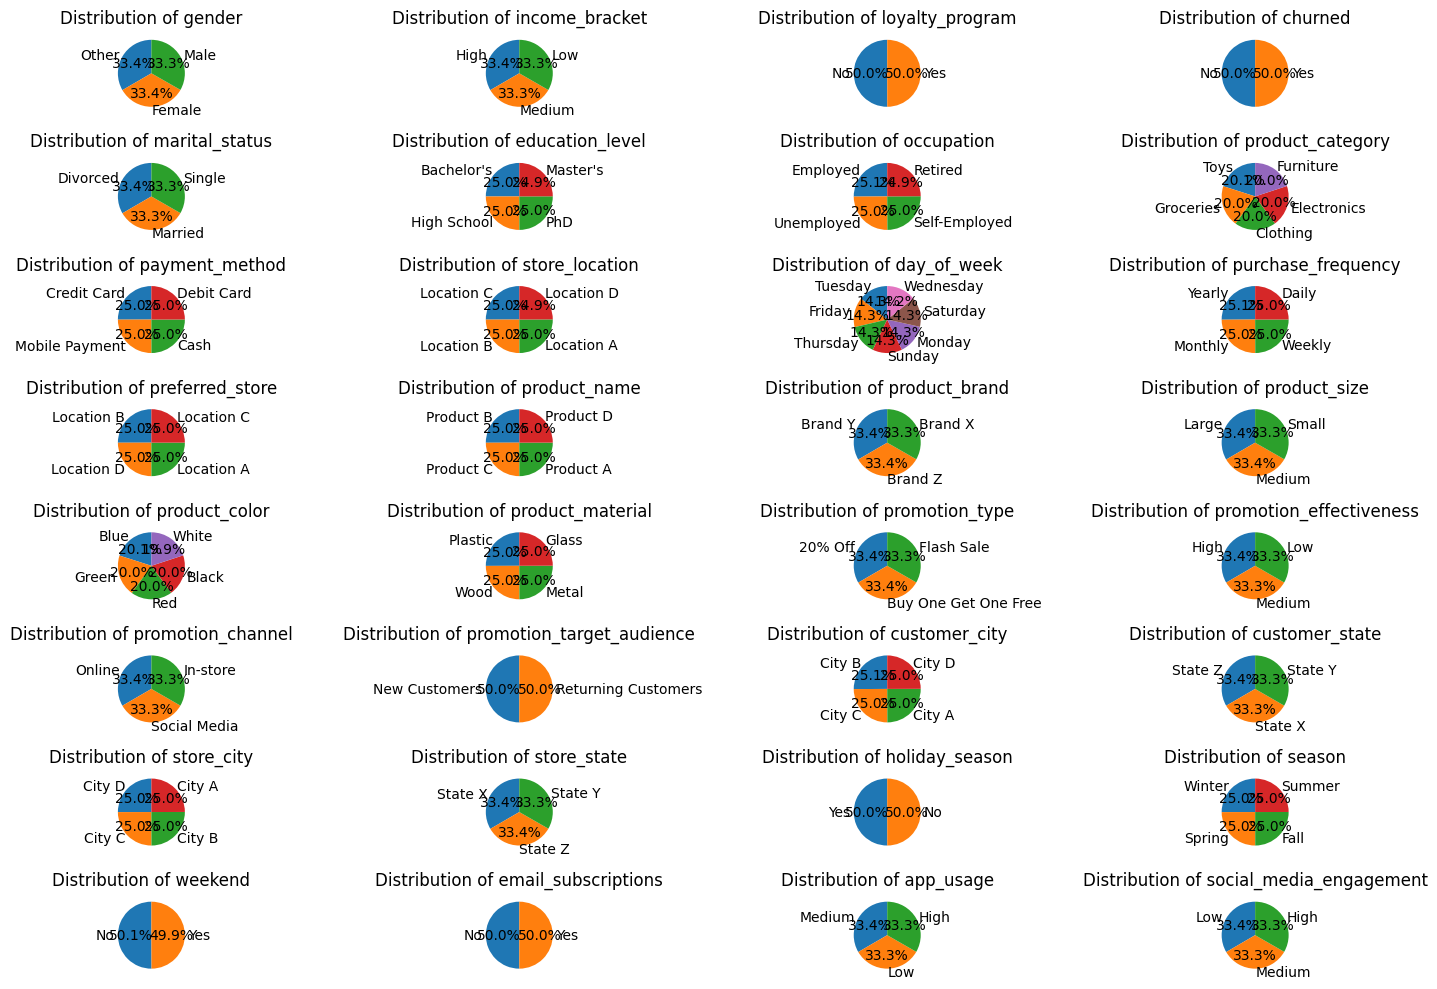

In [12]:
#visualise data
#use column names as titles, categories as x-axis, and values as y-axis, plot as pie chart
#subplot to contain all pie charts
plt.figure(figsize=(15, 10))
for i, col in enumerate(non_numeric_cols):
    plt.subplot(8, 4, i + 1)
    retail_data[col].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title(f'Distribution of {col}')
    plt.ylabel('')  # Hide the y-label for better aesthetics
plt.tight_layout()
plt.show()
#data is balanced, no need to oversample or undersample

#### Step 2: Feature engineering

We categorise the features by what topics they represent. This will help us practically reduce feature dimensions as we determine statistically significant features through plotting correlations and PCA.

In [15]:
list(processed_data.columns)

['age',
 'Male',
 'Other',
 'income_bracket',
 'loyalty_program',
 'membership_years',
 'churned',
 'Married',
 'Single',
 'number_of_children',
 'education_level',
 'Retired',
 'Self-Employed',
 'Unemployed',
 'transaction_date',
 'Electronics',
 'Furniture',
 'Groceries',
 'Toys',
 'quantity',
 'unit_price',
 'discount_applied',
 'Credit Card',
 'Debit Card',
 'Mobile Payment',
 'Location B',
 'Location C',
 'Location D',
 'transaction_hour',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday',
 'avg_purchase_value',
 'Monthly',
 'Weekly',
 'Yearly',
 'last_purchase_date',
 'avg_discount_used',
 'Location B',
 'Location C',
 'Location D',
 'online_purchases',
 'in_store_purchases',
 'avg_items_per_transaction',
 'avg_transaction_value',
 'total_returned_items',
 'total_returned_value',
 'total_sales',
 'total_transactions',
 'total_items_purchased',
 'total_discounts_received',
 'avg_spent_per_category',
 'max_single_purchase_value',
 'min_single_purchase_value',

In [22]:
feature_groups = {
    "demographic_cols": [
        'age', 'membership_years', 'number_of_children',
        'Male', 'Other',
        'income_bracket', 'loyalty_program', 'churned',
        'Married', 'Single',
        'education_level', 'Retired', 'Self-Employed', 'Unemployed',
        'City B', 'City C', 'City D',
        'State Y', 'State Z',
        'email_subscriptions'
    ],

    "transaction_behavior_cols": [
        'quantity', 'unit_price', 'discount_applied',
        'transaction_hour', 'days_since_last_purchase',
        'Monthly', 'Weekly', 'Yearly',
        'avg_items_per_transaction', 'avg_transaction_value', 'total_sales',
        'total_transactions', 'total_items_purchased', 'total_returned_items',
        'total_returned_value', 'total_discounts_received',
        'avg_spent_per_category', 'max_single_purchase_value',
        'min_single_purchase_value', 'avg_purchase_value',
        'avg_discount_used'
    ],

    "monetary_cols": [
        'unit_price', 'discount_applied', 'avg_purchase_value', 'avg_discount_used',
        'avg_transaction_value', 'total_sales', 'total_discounts_received',
        'max_single_purchase_value', 'min_single_purchase_value',
        'total_returned_value'
    ],

    "product_cols": [
        'product_rating', 'product_review_count', 'product_stock',
        'product_return_rate', 'product_weight',
        'Electronics', 'Furniture', 'Groceries', 'Toys',
        'Product B', 'Product C', 'Product D',
        'Brand Y', 'Brand Z',
        'Medium', 'Small', 
        'Blue', 'Green', 'Red', 'White',
        'Metal', 'Plastic', 'Wood',
        'product_shelf_life'
    ],

    "promotion_cols": [
        'Buy One Get One Free', 'Flash Sale',
        'Online', 'Social Media',
        'promotion_target_audience',
        'promotion_effectiveness',
    ],

    "store_cols": [
        'Location B', 'Location C', 'Location D',  # store or preferred store
        'City B', 'City C', 'City D',  # redundant with demographic? depends on usage
        'State Y', 'State Z',
        'distance_to_store'
    ],

    "online_cols": [
        'online_purchases', 'in_store_purchases',
        'website_visits', 'customer_support_calls',
        'app_usage', 'social_media_engagement'
    ],

    "time_cols": [
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday',
        'holiday_season', 'Spring', 'Summer', 'Winter', 'weekend',
        'week_sin', 'week_cos', 'month_sin', 'month_cos'
    ],

    "target_cols": [
        'churned',
        'promotion_effectiveness'
    ]
}

In [23]:
#separate features by category into a dictionary
grouped_feature_dfs = {}
for group_name, features in feature_groups.items():
    grouped_feature_dfs[group_name] = processed_data[features]
grouped_feature_dfs

{'demographic_cols':         age  membership_years  number_of_children  Male  Other  \
 0        56                 0                   3   0.0    1.0   
 1        69                 2                   2   0.0    0.0   
 2        46                 5                   3   0.0    0.0   
 3        32                 0                   2   0.0    0.0   
 4        60                 7                   2   0.0    0.0   
 ...     ...               ...                 ...   ...    ...   
 999995   39                 1                   4   0.0    0.0   
 999996   77                 4                   2   0.0    0.0   
 999997   67                 7                   3   1.0    0.0   
 999998   36                 1                   2   1.0    0.0   
 999999   71                 5                   0   0.0    1.0   
 
         income_bracket  loyalty_program  churned  Married  Single  ...  \
 0                  3.0              1.0      1.0      0.0     0.0  ...   
 1                  2.0 

In [24]:
y=grouped_feature_dfs['target_cols']

In [25]:
y

,churned,promotion_effectiveness
0,1.0,3.0
1,1.0,1.0
2,1.0,1.0
3,1.0,3.0
4,0.0,2.0
...,...,...
999995,0.0,3.0
999996,0.0,2.0
999997,0.0,3.0
999998,0.0,1.0


In [26]:
from sklearn.decomposition import PCA

def normalise_pca(df, scaler=StandardScaler(), n_components = 2):
    """
    Scales and applies PCA to a DataFrame, returning the top principal components
    and identifying the original features with the highest contributions to PC1.

    Parameters:
    - df: pd.DataFrame
        The input numeric DataFrame
    - scaler: sklearn scaler
        The scaler to use (default is StandardScaler)
    - n_components: int
        Number of PCA components to keep

    Returns:
    - pca_df: DataFrame with PCA components
    - top_features: Series of original features with highest contribution to PC1
    """
    feature_names = df.columns
    df_scaled = scaler.fit_transform(df)

    # Fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(df_scaled)

    # Get top features contributing to PC1
    def get_top_pca_features(pca_model, feature_names, component=0, top_n=5):
        loadings = pd.Series(pca_model.components_[component], index=feature_names)
        return loadings.abs().sort_values(ascending=False).head(top_n)

    top_features = get_top_pca_features(pca, feature_names, component=0, top_n=n_components)

    # Output PCA dataframe
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)], index=df.index)

    return top_features

In [27]:
#create dictionary to store all pca results for each group
pca_results = {}
for group_name, df in grouped_feature_dfs.items():
    if group_name == 'target_vars':
        continue
    n_components = len(feature_groups[group_name])
    pca_results[group_name] = normalise_pca(df, scaler=StandardScaler(), n_components=n_components)
pca_results

{'demographic_cols': Other                  0.421055
 Male                   0.420812
 Married                0.363984
 Single                 0.363635
 State Z                0.361538
 State Y                0.359772
 State Y                0.245722
 State Z                0.244938
 City D                 0.010199
 City B                 0.007947
 Self-Employed          0.006899
 City B                 0.006454
 churned                0.005944
 City D                 0.004995
 City C                 0.004217
 Unemployed             0.004035
 loyalty_program        0.003277
 number_of_children     0.002902
 City C                 0.002627
 email_subscriptions    0.002487
 dtype: float64,
 'transaction_behavior_cols': Yearly                       0.815085
 Monthly                      0.444501
 Weekly                       0.371251
 total_transactions           0.009529
 total_returned_items         0.005347
 avg_spent_per_category       0.005270
 total_discounts_received     0.004083
 

We are looking at the full output and choosing the approach whereby the significance of variables is assessed by segregating them into categories and comparing variance explained by each variable against its peers in the same family to determine the most significant variables to include in our clustering model.

In [35]:
grouped_feature_dfs['transaction_behavior_cols']['purchase_index']=(
    grouped_feature_dfs['transaction_behavior_cols']['Weekly'] * 1 +
    grouped_feature_dfs['transaction_behavior_cols']['Monthly'] * (1 / 4.33) +
    grouped_feature_dfs['transaction_behavior_cols']['Yearly'] * (1 / 52)
)

/var/folders/xq/pbtny36j0pl28vpcjxxht3_00000gn/T/ipykernel_38023/2896871201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_feature_dfs['transaction_behavior_cols']['purchase_index']=(


In [37]:
#checking output, these are the top features that can be included in the clustering model
#assume we are assessing online shopping behaviours only
chosen_features={}
chosen_features['transaction_behavior_cols'] = ['purchase_index']
chosen_features['monetary_cols'] = ['avg_purchase_value','discount_applied']
chosen_features['online_cols'] = ['online_purchases','social_media_engagement']

sum(len(v) for v in chosen_features.values())  # Total number of features chosen

5

#### Step 3: Clustering

In [42]:
#extract features
chosen_feature_dfs = {}
for group_name, features in chosen_features.items():
    chosen_feature_dfs[group_name] = grouped_feature_dfs[group_name][features]
#collapse all features into a single dataframe
X = pd.concat(chosen_feature_dfs.values(), axis=1)
#standardise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 1.68963315e+00,  1.10423491e+00,  1.73278777e+00,
         1.92436169e-01,  1.22598268e+00],
       [-7.67341264e-01,  9.76965270e-02,  4.85627110e-01,
        -5.01021005e-02,  1.48286927e-03],
       [ 1.68963315e+00, -5.72207693e-02,  6.93487221e-01,
        -1.15884847e+00,  1.48286927e-03],
       ...,
       [-7.67341264e-01,  3.31556624e-01,  1.66350107e+00,
        -8.47013557e-01,  1.48286927e-03],
       [-7.20091756e-01,  4.94262198e-02,  1.03992074e+00,
        -5.01021005e-02,  1.22598268e+00],
       [-7.20091756e-01, -8.94141674e-01,  1.10920744e+00,
         5.38919411e-01,  1.48286927e-03]])

In [48]:
from sklearn.cluster import KMeans
# Fit KMeans clustering model using elbow method to determine optimal number of clusters
def find_optimal_k(X, max_k=10):
    """
    Uses the elbow method to find the optimal number of clusters for KMeans.

    Parameters:
    - X: pd.DataFrame or np.ndarray
        The input data for clustering
    - max_k: int
        Maximum number of clusters to test

    Returns:
    - k_values: list of int
        List of k values tested
    - inertia_values: list of float
        Corresponding inertia values for each k
    """
    k_values = []
    inertia_values = []

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        k_values.append(k)
        inertia_values.append(kmeans.inertia_)
    #plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertia_values, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid()
    plt.show()

    return k_values, inertia_values

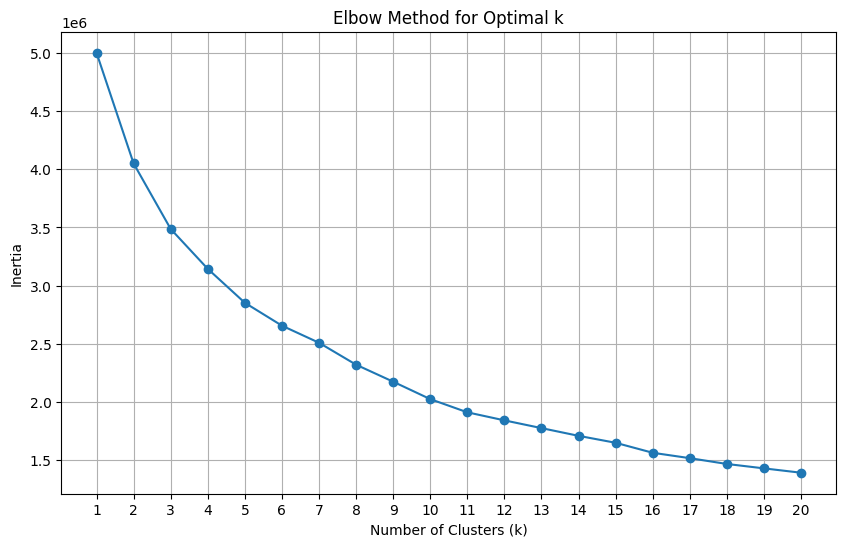

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [4999999.999999983,
  4049556.7460574373,
  3486912.478009345,
  3144392.638165221,
  2852984.282979105,
  2656584.366058494,
  2509799.9894015733,
  2321410.2771284324,
  2175406.1116763083,
  2025894.3735112338,
  1912541.7449884973,
  1843421.7809189893,
  1776865.8854708006,
  1710574.3893422764,
  1650873.9394868384,
  1565086.8632328354,
  1518826.3723876772,
  1468943.5419390684,
  1431201.5033384475,
  1393856.174081699])

In [49]:
#assume that online shoppers do not care about store location
#assume we have infinite stock of products of all brands and colours at the moment
find_optimal_k(X=X_scaled, max_k=20)

In [52]:
#optimal k=7 visually determined from the elbow curve
# Fit KMeans with optimal k
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X_scaled)
# Add cluster labels to the original DataFrame
processed_data['cluster_label'] = kmeans.labels_